*Nombre de Grupos*: Perception Roll Failed

*Integrantes*: Santiago Rocca, Maximiliano Fisz

# **Laboratorio 2: Algoritmo Bag of Words**

El modelo Bag of Words se originó en procesamiento de texto, donde cada documento es representado como un vector de frecuencias de palabras, sin tener en cuenta su orden. De esta manera, podemos ganar informacion de las imagenes comparandolas con ejemplos ya conocidos.

 Esta idea se adapta al dominio de imágenes mediante el concepto de palabras visuales.

## **Palabras Visuales**

Las palabaras visuales seran los puntos en el espacio de caracteristicas que mejor engloban los cluster de keypoints encontrados en el DataSet de entrenamiento. Estas representaran una forma abstracta de los distintas caracteristicas que formaban el cluster.

## **Recoleccion de Palabras Visuales o creacion del Corpus Visual**

Usaremos un dataset chico de **500 imagenes** para recolectar nuestras palabras visuales y crear un **Corpus**. El DataSet contendra 3 categorias: pescados, iglesias y Springer spaniel inglés (una raza de perro).

El Dataset es un subset de **imagenette2**, que de por si es un subset de imagenet (la base de datos mas grande del mundo)

[**Link DataSet Para el Collab**](https://drive.google.com/drive/folders/1TivSa9neqUMrZm5HVNQ4dBYGdG6HMdi5?usp=drive_link)

[**Link imagenette2**](https://huggingface.co/datasets/frgfm/imagenette/viewer/160px/train)

[**Link imagenet**](https://www.image-net.org/)



Para poder utilizar el DataSet, recomendamos subirlo al collab o directamente ejecutarlo desde drive (Hace falta darle permiso para acceder a archivos de Drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
data_path = "/content/drive/MyDrive/DataSet/BOW/"
print(os.listdir(data_path))

['perro', 'iglesia', 'radio']


In [3]:
!pip install tqdm  # Run once

In [4]:
from skimage.io import imread
from skimage.transform import resize
import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Cargamos el nombre de las distintas imagens del dataset
image_files = glob.glob(data_path + '/*/*.JPEG')
print(f"Imagenes Totales: {len(image_files)}")

# Cargamos cada una de las imagenes en el DataSet.
imagenesDeEntrenamiento = []
for path in tqdm(image_files, desc="Cargando Imagenes"):
    imagenesDeEntrenamiento.append(imread(path, as_gray=True))

Imagenes Totales: 503


Cargando Imagenes:   0%|          | 0/503 [00:00<?, ?it/s]

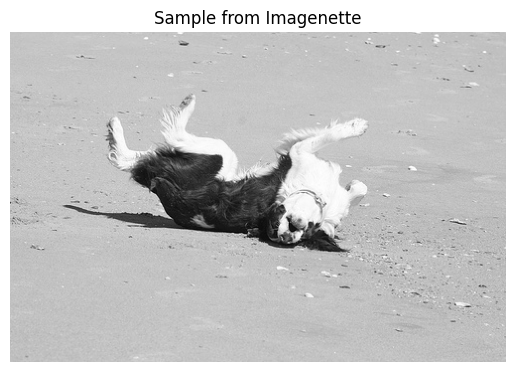

In [5]:
imagenEjemplo = imagenesDeEntrenamiento[69]
plt.imshow(imagenEjemplo,cmap='gray')
plt.axis('off')
plt.title("Sample from Imagenette")
plt.show()

### **Recoleccion de Features**

Por cada una de las imagenes, tendremos que recolectar sus descriptores que luego se usaran para identificar las palabras visuales que conformaran nuestro corpus. Para esto utilizaremos el descriptor **SIFT** visto en clase.

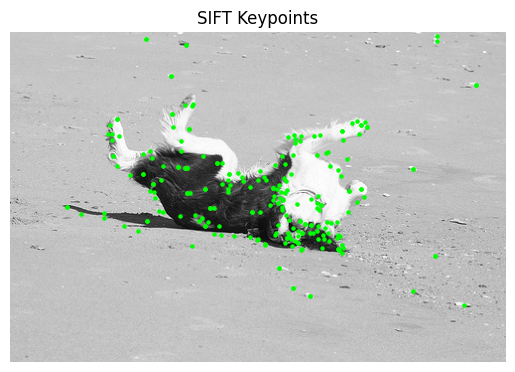

In [6]:
from skimage.feature import SIFT

# Extraemos los descriptores de SIFT
sift = SIFT()
sift.detect_and_extract(imagenEjemplo)

# Los Mostramos
fig, ax = plt.subplots()
ax.imshow(imagenEjemplo, cmap='gray')
ax.scatter(sift.keypoints[:, 1], sift.keypoints[:, 0], s=5, c='lime')
ax.set_title('SIFT Keypoints')
ax.axis('off')
plt.show()

In [8]:
from skimage.feature import SIFT
from skimage.color import rgb2gray
import numpy as np

# Inicizamos los vectores donde guardaremos los keypoints (no haran falta) y los
# descriptores (lo que usaremos para crear las palabras)
keypoints = []
descriptores = []

for imagen in tqdm(imagenesDeEntrenamiento, desc="Extrayendo Features"):

    sift = SIFT()

    # Detectamos y extraemos las features
    sift.detect_and_extract(imagen)

    # Recolectamos lo encontrado
    keypoints.append(sift.keypoints)
    descriptores.append(sift.descriptors)

Extrayendo Features:   0%|          | 0/503 [00:00<?, ?it/s]

In [9]:
matrizDescriptores = []
# Extraemos los descriptores de cada imagen y los juntamos en una gran matriz de numpy
for img_descriptors in descriptores:
    # Extraemos cada uno de los descriptores de una imagen
    for descriptor in img_descriptors:
        matrizDescriptores.append(descriptor)

# Convertimos en una sola matriz de numpy
matrizDescriptores = np.stack(matrizDescriptores, dtype=float)

In [10]:
# check the shape
matrizDescriptores.shape

(545714, 128)

### **Calculamos nuestras palabras visuales**

Nuestras palabaras visuales seran el **Centroide** de los Cluster de Caracteristicas encontrados en nuestro DataSet.

Para esto utilizaremos la funcion de `Kmeans` de Scipy, que nos dejara especificar en cuanto clusters querremos dividir nuestras caracteristicas encontradas.

In [11]:
from scipy.cluster.vq import kmeans
# k sera la cantidad de Clusters que identificara, es decir, nuestras palabaras visuales finales
k = 200

# tomara aproximadamente 10 minutos en calcular los centroides.
corpus, varianza = kmeans(matrizDescriptores, k, 1)

## Descripcion de nuestras imagenes de entrenamiento
**bold text**
Ahora que tenemos nuestro **corpus visual**, nuestro conjunto de palabras visuales, nos queda utilizarlo para describrir nuestras imagenes.  

Para esto, clasificaremos los descriptores encontrados anteriormente segun este nuevo corpus, y describiremos a las imagenes con la **frecuencia** en que aparece cada palabra visual.

### **Clasificacion de los Descriptores**

Para clasificar los descriptores, eligiremos al centroide que mas cerca esta del descriptor

In [12]:
from scipy.cluster.vq import vq

# Realizamos el mapeo entre cada descriptor a una palabra visual por cada imagen
palabrasVisuales = []
for descriptoresDeImagen in descriptores:
    # Por cada imagen, mapeamos los descriptores a la entrada mas cercana del corpus
    palabrasVisualesDeImagen, _ = vq(descriptoresDeImagen, corpus)
    palabrasVisuales.append(palabrasVisualesDeImagen)

In [13]:
# Algunas palabras visuales de la imagen 0
# Lo que veremos sera el index de la palabra en el corpus.
palabrasVisuales[0][:5], len(palabrasVisuales[0])

(array([ 88,  66, 161,  81, 124], dtype=int32), 1246)

In [14]:
# El centroide que representara a la palabra visual 88 tendra las mismas dimensiones que el resto de los descriptores
corpus[88].shape

(128,)

### **Frecuencia de las palabras**

Ahora que ya clasificamos los descriptores de cada imagen en relacion a nuestro corpus, podemos describir cada una de las imagenes como la frecuencia de cada una de las palabras.

In [38]:
matrizDeFrecuencias = []
for palabrasVisualesEnImagen in palabrasVisuales:
    # Creamos un vector de frecuencias por cada vector.
    frecuencia, _ = np.histogram(palabrasVisualesEnImagen, bins=200, range=(0,199), density=None, weights=None)
    matrizDeFrecuencias.append(frecuencia)
# Unimos todo en una gran matriz de numpy.
matrizDeFrecuencias = np.stack(matrizDeFrecuencias)

In [39]:
matrizDeFrecuencias.shape

(503, 200)

In [40]:
# Comparamos con los valores que habiamos encontrado antes para la imagen 0.
for i in palabrasVisuales[0][:5]:
    print(f"{i}: {matrizDeFrecuencias[0][i]}")

88: 10
66: 10
161: 3
81: 13
124: 7


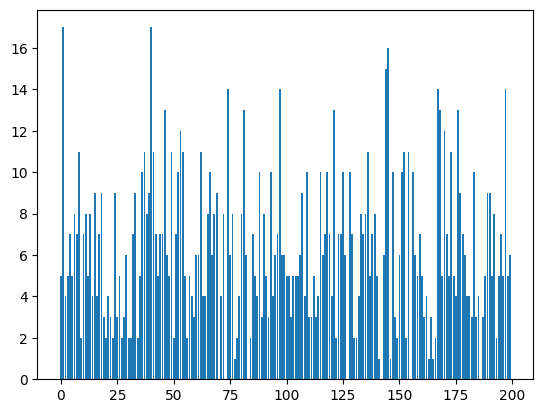

In [41]:
# visualize the frequency vector for image 0
plt.bar(list(range(k)), matrizDeFrecuencias[0])
plt.show()

## **Tf-idf**
Como en **texto**, algunas palabras seran mas importante que otras para describir el contenido de una imagen. Por ejemplo, la palabra "***entonces***" no nos es util por si sola para poder describir un escrito, ya que varios documentos de contenidos completamente opuestos pueden contener esta palabra.

Por estas razones, reduciremos la importancia de las palabras que aparacen en la mayoria de nuestras imagenes, ya que una palabra visual que toda imagen contiene no es util para diferenciarlas. **Para esto utilizaremos la formula Tf-idf**

$$
\text{Tf-idf}_{t,d} = \text{tf}_{t,d} ⋅ log(\frac{N}{\text{df}_t})
$$
donde
- $\text{Tf-idf}_{t,d}$ sera el nuevo valor de la palabra $t$ para la imagen $d$
- $\text{tf}_{t,d}$ era la frecuencia de la palabra $t$ para la imagen $d$
- $N$ es la cantidad de imagenes totales
- $\text{df}_t$ es la cantidad de imagenes en la que la palabra $t$ aparece al menos una vez.


### ***Ejercicio***: Aplicar Tf-idf en la matriz de frecuencia.  

In [42]:
N = len(imagenesDeEntrenamiento)

# ...
copiaMDF = matrizDeFrecuencias.copy()

for imagen in copiaMDF:
  for frecuencia in range(0, 200):
    dft = 0
    for i in copiaMDF:
      if i[frecuencia] > 0:
        dft += 1
    imagen[frecuencia] = imagen[frecuencia] * np.log(N / dft)

# tfidf sera la nueva matriz de frecuencias habiendo aplicado tfidf.
# mantengan el mismo orden de imagenes que en en matrizFrecuencias
tfidf = copiaMDF



In [43]:
tfidf.shape, tfidf[0][:5]

((503, 200), array([1, 4, 1, 0, 1]))

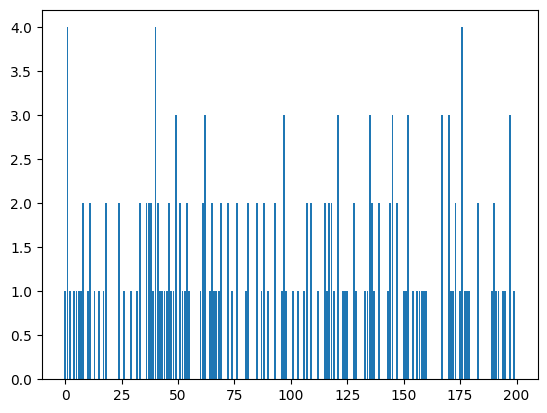

In [44]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

# **Busqueda de imagenes segun su descriptor**

Ahora que cada imagen esta descrita utilizando Bag Of Words, podemos tomar una medida de su semejanza calculando la distancia coseno entre su descriptores.

$$ \text{similitud coseno} = \frac{A \cdot B}{|A| ⋅ |B|}$$


Esta medida nos hablara sobre el angulo entre los dos vectores de caracteristicas, cuanto mas cercano a 1, mas similar sera el contenido de las imagenes que describen

200: 1.0


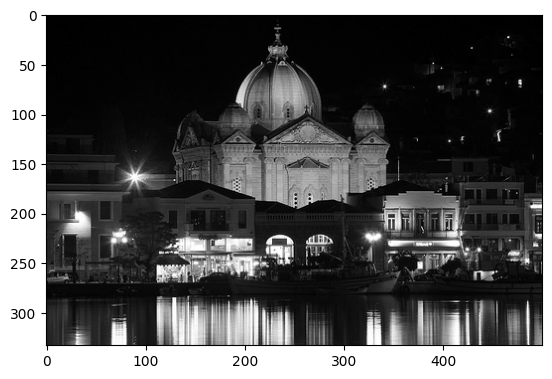

243: 0.6742


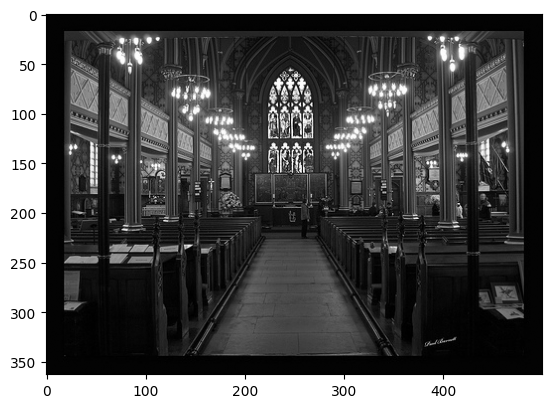

260: 0.6527


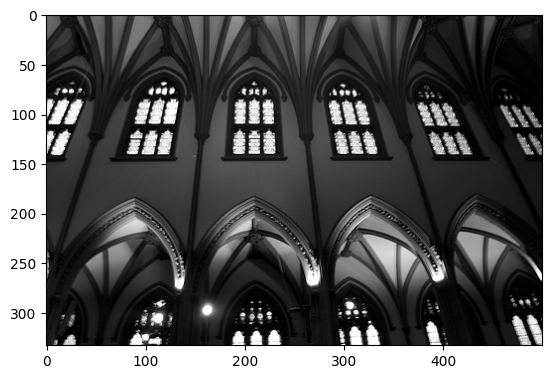

247: 0.6466


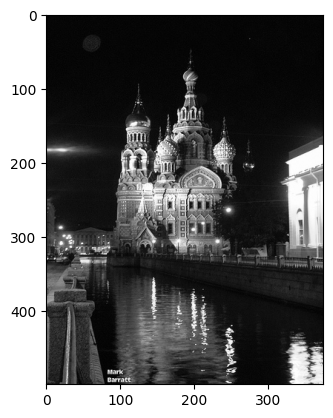

173: 0.6279


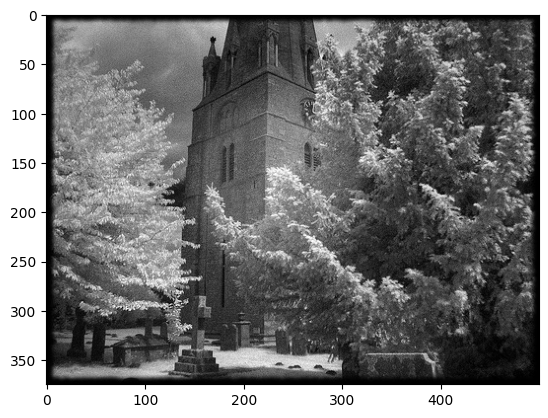

In [45]:
from numpy.linalg import norm

#Mostramos las k imagenes con mayor similitud
top_k = 5

# Elegimos el id de la imagen a Buscar
i = 200

# Recolectamos el descriptor de la imagen a buscar
a = tfidf[i]
b = tfidf  # Buscamos en el resto de la base de imagenes

# Calculamos la distancia coseno de cada una de las imagens contra la imagen de busqueda
distanciaCoseno = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))

#Elegimos los primeros k indices con mejor puntaje
idx = np.argsort(-distanciaCoseno)[:top_k]

# Los mostramos
for i in idx:
    print(f"{i}: {round(distanciaCoseno[i], 4)}")
    plt.imshow(imagenesDeEntrenamiento[i], cmap='gray')
    plt.show()